# Running this notebook

**The visualizations in this notebook will run in [jupyter lab](https://github.com/jupyterlab/jupyterlab#installation), not jupyter notebook. Google colab is not supported either. VS Code notebooks _might_ work but that has not been tested.** See the fastplotlib supported frameworks for more info: https://github.com/fastplotlib/fastplotlib/#supported-frameworks 

In [19]:
from copy import deepcopy
import os

import numpy as np
import pandas as pd
import tifffile
from ipywidgets import IntSlider, VBox
import fastplotlib as fpl

from caiman.motion_correction import high_pass_filter_space
from caiman.summary_images import correlation_pnr

import mesmerize_core as mc
from mesmerize_core.arrays import LazyTiff
from mesmerize_viz import *
from decode_lab_code.calcium_imaging import calcium_imaging_utils

from mesmerize_core.caiman_extensions.cnmf import cnmf_cache

from avi_r import AVIReader

import matplotlib.pyplot as plt
import numpy as np

In [2]:
if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)


In [ ]:
# Mac users!
# temporary patch for Mac, won't be necessary in next release
# Thanks Ryan Ly for the PR! :D I need to dig into it more before merging
# conda_prefix_1_str = os.environ['CONDA_PREFIX'].replace(os.path.join(' ', 'envs', 'mescore')[1:], '')
# os.environ['CONDA_PREFIX_1'] = conda_prefix_1_str

In [3]:
# This is just a pandas table display formatting option
pd.options.display.max_colwidth = 120

# Paths

`mesmerize-core` helps manage the outputs of caiman algorithms and organizes "parameter variants" - the output of a given combination of input data and algorithm parameters. In order to run the algorithms you must tell `mesmerize-core` where your _input data_ are located and decide on a **top level raw data directory**. For example consider the following directory structure of experimental data (you may organize your raw data however you wish, this is just an example). We can see that all the experimental data lies under `/data/group_name/my_name/exp_data`. Therefore we can use this `exp_data` dir as a `parent raw data path`. `mesmerize-core` will then only store the _relative_ paths to the raw data files, this allows you to move datasets between computers and filesystems. `mesmerize-core` does not store any hard file paths, only relative paths.

```
/data/group_name/my_name
                        └── exp_data
                            ├── axonal_imaging
                            │   ├── mouse_1
                            │   │   ├── exp_a.tiff
                            │   │   ├── exp_b.tiff
                            │   │   └── exp_c.tiff
                            │   ├── mouse_2
                            │   │   ├── exp_a.tiff
                            │   │   └── exp_b.tiff
                            │   └── mouse_3
                            └── hippocampus_imaging
                                ├── mouse_1
                                │   ├── exp_a.tiff
                                │   ├── exp_b.tiff
                                │   └── exp_c.tiff
                                ├── mouse_2
                                └── mouse_3
```

**For this demo set the `caiman_data` dir as the parent raw data path**

Sidenote: We recommend using [pathlib](https://docs.python.org/3/library/pathlib.html) instead of manually managing paths as strings. `pathlib` is just a part of the Python standard library, it makes it much easier to deal with paths and saves a lot of time in the long-run! It also makes your paths compatible across operating systems. Therefore even if you are on Windows you can use the regular `/` for paths, you do not have to worry about the strangeness of `\\` and `\`

# Load data: Rerun this cell if your machine crashes at any point and you want to pick back up

In [67]:
# directory stuff
folder_name = "/Users/js0403/miniscope/122A_session2_nwbfile/"
file_name = "122A_session2.tif"
frame_rate = 30
mc.set_parent_raw_data_path(folder_name)

# batch stuff - don't worry about
batch_path = mc.get_parent_raw_data_path().joinpath("mesmerize-batch/batch.pickle")
try:
    # create a new batch
    df = mc.create_batch(batch_path)
    print("Created batch")
except:
    # to load existing batches use `load_batch()`
    df = mc.load_batch(batch_path)
    print("Loaded batch")
df

Loaded batch


,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid


# Load in movie

In [68]:
# get the actual file name
movie_path  = mc.get_parent_raw_data_path().joinpath(file_name) # add to moviepath
print(movie_path)

/Users/js0403/miniscope/122A_session2_nwbfile/122A_session2.tif


# gSig_filt

A high-pass spatial filter is useful for motion correction of miniscope 1p data, or other data which has large amounts of low frequency background flutuations.

The `gSig_filt` param sets the `sigma` of the gaussian kernel used for filtering. We can use fastplotlib to visualize the effects of this parameter. We want to remove the low frequency spatial information from the image to create better template images for motion correction.

Note that this is different from the `gSig` parameter used in CNMF!

In [69]:
# get out input movie
# if it is memmapable you can use tifffile.memmap
# for other formats you can try LazyTiff, or any suitable lazy loader
#movie = tifffile.imread(movie_path)
movie = tifffile.memmap(movie_path)

<Axes: >

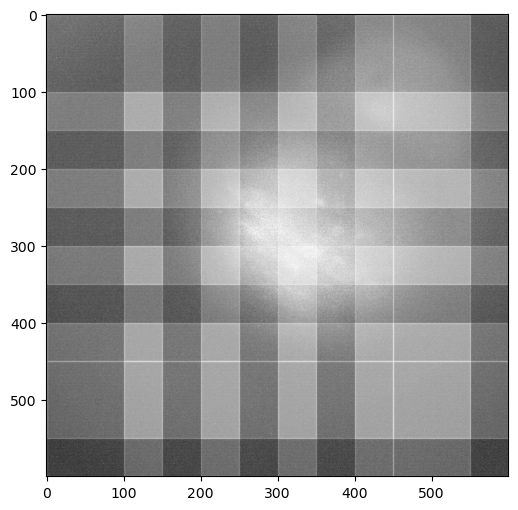

In [71]:
stride = 100; overlap = 50; width = stride+overlap; rf = int(width/2)
calcium_imaging_utils.view_quilt(template_image=movie[0,:,:],stride=stride,overlap=overlap)

In [72]:
# create a slider for gSig_filt
slider_gsig_filt = IntSlider(value=3, min=1, max=33, step=2,  description="gSig_filt")

def apply_filter(frame):
    # read slider value
    gSig_filt = (slider_gsig_filt.value, slider_gsig_filt.value)
    
    # apply filter
    return high_pass_filter_space(frame, gSig_filt)

# we can use frame_apply feature of `ImageWidget` to apply 
# the filter before displaying frames
funcs = {
    # data_index: function
    1: apply_filter  # filter shown on right plot, index 1
}

# input movie will be shown on left, filtered on right
iw_gs = fpl.ImageWidget(
    data=[movie, movie.copy()],
    frame_apply=funcs,
    names=["raw", "filtered"],
    grid_plot_kwargs={"size": (1200, 600)},
    cmap="gnuplot2"
)

def force_update(*args):
    # kinda hacky but forces the images to update 
    # when the gSig_filt slider is moved
    iw_gs.current_index = iw_gs.current_index
    iw_gs.reset_vmin_vmax()

iw_gs.reset_vmin_vmax()
slider_gsig_filt.observe(force_update, "value")

# add a column to overlay functional activity on structural video
#struct_rgba = np.zeros((512, 512, 4), dtype=np.float32)
#struct_rgba[:, :, 1] = struct_movie[0]
#struct_rgba[..., -1] = 0.8
#iw_gs.gridplot["filtered"].add_image(struct_rgba, name='struct')
#iw_gs.gridplot["filtered"]
#iw_gs.gridplot["filtered"]["struct"].data[..., -1] = 0.5
VBox([iw_gs.show(), slider_gsig_filt])
#iw_gs.show(sidecar=True)


RFBOutputContext()

/Users/js0403/anaconda3/envs/caiman/lib/python3.11/site-packages/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


# reset vmin vmax when necessary!

# Motion correction parameters

Parameters for all algos have the following structure:

```python
{"main": {... params directly passed to caiman}}
```

In [73]:
smooth_factor = 9 # set smooth_factor to be gSig_filt
params =\
{
    "main":
    {
        "gSig_filt": (smooth_factor, smooth_factor), # a gSig_filt value that brings out "landmarks" in the movie
        "pw_rigid": True,
        "max_shifts": (5, 5),
        "strides": (stride, stride),
        "overlaps": (overlap, overlap),
        "max_deviation_rigid": 3,
        "border_nan": "copy",
    }
}

# Add a "batch item", this is the combination of:
* algorithm to run, `algo`
* input movie to run the algorithm on, `input_movie_path`
* parameters for the specified algorithm, `params`
* a name for you to keep track of things, usually the same as the movie filename, `item_name`

In [74]:
df.caiman.add_item(
    algo="mcorr",
    input_movie_path=movie_path,
    params=params,
    item_name=movie_path.stem
)

df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,122A_session2,122A_session2.tif,"{'main': {'gSig_filt': (9, 9), 'pw_rigid': True, 'max_shifts': (5, 5), 'strides': (100, 100), 'overlaps': (50, 50), ...",None,2023-12-22T14:31:02,None,None,None,ca78e849-cd8b-4864-a81d-c618c90bc850


We can now see that there is one item, a.k.a. row or pandas `Series`, in the batch dataframe, we can add another item with the same input movie but with different parameters.

**When adding batch items with the same `input_movie_path` (i.e. same input movie but different parameters) it is useful to give them the same `item_name`.**

Let's try one more with different `gSig_filt`

# Run an item

There is only one item in this DataFrame and it is located at index `0`. You can run a row using `df.iloc[index].caiman.run()`

Technical notes: On Linux & Mac it will run in subprocess but on Windows it will run in the local kernel. If using the subprocess backend (only Linux & Mac) you can use `run(wait=False)` if you don't want to block the kernel while running. 

In [9]:
df.iloc[-1].caiman.run()

# reload dataframe from disk when done
df = df.caiman.reload_from_disk()

starting mc


100%|██████████| 1/1 [01:06<00:00, 66.06s/it]
Process SpawnPoolWorker-11:
Process SpawnPoolWorker-4:
Process SpawnPoolWorker-6:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/js0403/anaconda3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/js0403/anaconda3/envs/caiman/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/js0403/anaconda3/envs/caiman/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/js0403/anaconda3/envs/caiman/lib/python3.11/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/js0403/anaconda3/envs/caiman/lib/python3.11/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
           ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
  File "/Users/js0403/anaconda3/envs/caiman/lib/pytho

mc finished successfully!
computing projections
Computing correlation image
mc failed, stored traceback in output


ValueError: #!/bin/bash
export CONDA_PREFIX=/Users/js0403/anaconda3/envs/caiman
export CONDA_PYTHON_EXE=/Users/js0403/anaconda3/bin/python
export CONDA_PREFIX_1=/Users/js0403/anaconda3
export OPENBLAS_NUM_THREADS=1
export MKL_NUM_THREADS=1
python /Users/js0403/anaconda3/envs/caiman/lib/python3.11/site-packages/mesmerize_core/algorithms/mcorr.py --batch-path /Users/js0403/miniscope/122A_session2_nwbfile/mesmerize-batch/batch.pickle --uuid b5298fed-12da-4d0c-ba00-0066bcb8bfa3 --data-path /Users/js0403/miniscope/122A_session2_nwbfile

/Users/js0403/anaconda3/envs/caiman/lib/python3.11/multiprocessing/resource_tracker.py:254: UserWarning: resource_tracker: There appear to be 16 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear to be %d '


disable the spatial filter. Reset vmin vmax after removing it.

In [ ]:
df

# CNMF
## corr-pnr seeding

This visualization is to help determine values for `min_corr` (correlation) and `min_pnr` (peak to noise ratio) for seeding CNMFE. Pixels below these thresholds will be excluded from the results.

If `correlation_pnr` takes a long time you can increase the subsample to make it larger than `2`. Example: `mcorr_movie[::5]`

You should try different values of `gSig`, this is different from `gSig_filt`. You will use this gSig as a CNMFE param as well.

In [12]:
# get the motion corrected output, this is a memmap array
mcorr_movie = df.iloc[-1].mcorr.get_output()

gSig = smooth_factor
corr, pnr = correlation_pnr(mcorr_movie[::2], gSig=gSig, swap_dim=False)

In [13]:
# to show the correlation and pnr images
iw_corr_pnr = fpl.ImageWidget(
    [corr, pnr], 
    names=["corr", "pnr"],
    grid_plot_kwargs={"size": (650, 300)},
    cmap="turbo",
)

# mcorr vids, we will display thresholded mcorr vids
mcorr_vids = [mcorr_movie.astype(np.float32) for i in range(4)]

# sync the threshold image widget with the corr-pnr plot
threshold_grid_plot_kwargs = {
    "controllers": [[iw_corr_pnr.gridplot["corr"].controller]*2]*2,
    "size": (650, 600)
}

iw_thres_movie = fpl.ImageWidget(
    mcorr_vids, 
    names=["over corr threshold", "over pnr threshold", "under corr threshold", "under pnr threshold"],
    # sync this with the corr-pnr plot
    grid_plot_kwargs=threshold_grid_plot_kwargs,
    cmap="gnuplot2"
)

# display threshold of the spatially filtered movie
def spatial_filter(frame):
    f = high_pass_filter_space(frame, (3, 3))
    return f


# threshold
def threshold(frame, mask):
    # optionally use spatial filter
    t = spatial_filter(frame)
    
    t = t.copy()
    
    t[mask] = t.min()
    
    return t

# Set the thresholded images using the vmin set from top subplots
# dict of threshold lambda wrappers to set on ImageWidget
# this sets the frame_apply for each subplot
threshold_funcs = {
    0: lambda frame: threshold(frame, corr < iw_corr_pnr.gridplot["corr"].graphics[0].cmap.vmin),
    1: lambda frame: threshold(frame, pnr < iw_corr_pnr.gridplot["pnr"].graphics[0].cmap.vmin),
    2: lambda frame: threshold(frame, corr > iw_corr_pnr.gridplot["corr"].graphics[0].cmap.vmin),
    3: lambda frame: threshold(frame, pnr > iw_corr_pnr.gridplot["pnr"].graphics[0].cmap.vmin)
}

# set the dict of lambda wrappers
iw_thres_movie.frame_apply = threshold_funcs

# update threshold plots when the corr pnr sliders move
def update_threshold_plots(*args):
    iw_thres_movie.current_index = iw_thres_movie.current_index

# this will get easier in the future
iw_corr_pnr.gridplot["corr"].docks["right"]["histogram_lut"].linear_region.selection.add_event_handler(update_threshold_plots)
iw_corr_pnr.gridplot["pnr"].docks["right"]["histogram_lut"].linear_region.selection.add_event_handler(update_threshold_plots)

VBox([iw_corr_pnr.show(), iw_thres_movie.show()])

RFBOutputContext()

/Users/js0403/anaconda3/envs/mescore/lib/python3.11/site-packages/fastplotlib/graphics/_features/_base.py:34: UserWarning: converting float64 array to float32
  warn(f"converting {array.dtype} array to float32")


RFBOutputContext()

In [19]:
import scipy.stats as ss
z_corr = ss.zscore(corr,axis=0)
z_pnr = ss.zscore(pnr,axis=0)
z_struct = ss.zscore(struct_movie,axis=0)

In [23]:
# to show the correlation and pnr images
iw_corr_pnr = fpl.ImageWidget(
    [corr, pnr], 
    names=["corr", "pnr"],
    grid_plot_kwargs={"size": (650, 300)},
    cmap="turbo",
)

# mcorr vids, we will display thresholded mcorr vids
mcorr_vids = [mcorr_movie.astype(np.float32) for i in range(4)]

# sync the threshold image widget with the corr-pnr plot
threshold_grid_plot_kwargs = {
    "controllers": [[iw_corr_pnr.gridplot["corr"].controller]*2]*2,
    "size": (650, 600)
}

iw_thres_movie = fpl.ImageWidget(
    mcorr_vids, 
    names=["over corr threshold", "over pnr threshold", "under corr threshold", "under pnr threshold"],
    # sync this with the corr-pnr plot
    grid_plot_kwargs=threshold_grid_plot_kwargs,
    cmap="gnuplot2"
)

# display threshold of the spatially filtered movie
def spatial_filter(frame):
    f = high_pass_filter_space(frame, (3, 3))
    return f


# threshold
def threshold(frame, mask):
    # optionally use spatial filter
    t = spatial_filter(frame)
    
    t = t.copy()
    
    t[mask] = t.min()
    
    return t

# Set the thresholded images using the vmin set from top subplots
# dict of threshold lambda wrappers to set on ImageWidget
# this sets the frame_apply for each subplot
threshold_funcs = {
    0: lambda frame: threshold(frame, corr < iw_corr_pnr.gridplot["corr"].graphics[0].cmap.vmin),
    1: lambda frame: threshold(frame, pnr < iw_corr_pnr.gridplot["pnr"].graphics[0].cmap.vmin),
    2: lambda frame: threshold(frame, corr > iw_corr_pnr.gridplot["corr"].graphics[0].cmap.vmin),
    3: lambda frame: threshold(frame, pnr > iw_corr_pnr.gridplot["pnr"].graphics[0].cmap.vmin)
}

# set the dict of lambda wrappers
iw_thres_movie.frame_apply = threshold_funcs

# update threshold plots when the corr pnr sliders move
def update_threshold_plots(*args):
    iw_thres_movie.current_index = iw_thres_movie.current_index

# this will get easier in the future
iw_corr_pnr.gridplot["corr"].docks["right"]["histogram_lut"].linear_region.selection.add_event_handler(update_threshold_plots)
iw_corr_pnr.gridplot["pnr"].docks["right"]["histogram_lut"].linear_region.selection.add_event_handler(update_threshold_plots)

# add a column to overlay functional activity on structural video
struct_rgba = np.zeros((512, 512, 4), dtype=np.float32)
struct_rgba[:, :, 1] = struct_movie[0]
struct_rgba[..., -1] = 0.5
iw_corr_pnr.gridplot["corr"].add_image(struct_rgba, name='struct')
iw_corr_pnr.gridplot["corr"]
iw_corr_pnr.gridplot["corr"]["struct"].data[..., -1] = .8

struct_rgba = np.zeros((512, 512, 4), dtype=np.float32)
struct_rgba[:, :, 0] = struct_movie[0] 
struct_rgba[..., -1] = 0.5
iw_corr_pnr.gridplot["pnr"].add_image(struct_rgba, name='struct')
iw_corr_pnr.gridplot["pnr"]
iw_corr_pnr.gridplot["pnr"]["struct"].data[..., -1] = .8

#names=["corr", "pnr"],

# scale intensity of background
VBox([iw_corr_pnr.show()])

RFBOutputContext()

RFBOutputContext()

In [149]:
struct_rgba.shape

(512, 512, 4)

In [134]:
struct_movie.shape

(560, 512, 512)

In [136]:
struct_movie[1,:,:].shape

(512, 512)

In [138]:
corr.shape

(512, 512)

In [140]:
np.min(corr)

1.0000126

# corr and pnr values from the plot

In [ ]:
corr_pnr = {
    'min_corr': iw_corr_pnr.gridplot["corr"].graphics[0].cmap.vmin, # corr value from previous plot
    'min_pnr': iw_corr_pnr.gridplot["pnr"].graphics[0].cmap.vmin,  # PNR value from previous plot
}
corr_pnr

In [ ]:
params_cnmfe =\
{
    "main":
    {
        'method_init': 'corr_pnr',  # use this for 1 photon
        'K': None,
        'gSig': (gSig, gSig),
        'gSiz': (4 * gSig + 1, 4 * gSig + 1),
        'merge_thr': 0.7,
        'p': 1,
        'tsub': 2,
        'ssub': 1,
        'rf': 40,
        'stride': 20,
        'only_init': True,    # set it to True to run CNMF-E
        'nb': 0,
        'nb_patch': 0,
        'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
        'low_rank_background': None,
        'update_background_components': True,  # sometimes setting to False improve the results
        'normalize_init': False,               # just leave as is
        'center_psf': True,                    # leave as is for 1 photon
        'ssub_B': 2,
        'ring_size_factor': 1.4,
        'del_duplicates': True,                # whether to remove duplicates from initialization
        **corr_pnr # unpack corr_pnr vals into here
    }
}

# Add a single cnmf item to the batch

When you use `algo="cnmfe"`, it basically forces the following parameters:
```python
"method_init": "corr_pnr",
"n_processes": n_processes,
"only_init": True,  # for 1p
"center_psf": True,  # for 1p
"normalize_init": False,  # for 1p
```

In [ ]:
df.caiman.add_item(
    algo="cnmfe",
    input_movie_path=df.iloc[0],
    params=params_cnmfe,
    item_name=df.iloc[0]["item_name"]
)

df

# Parameter search

Just like with motion correction, we can use loops to add multiple parameter variants. This is useful to perform a parameter search to find the params that work best for your dataset. Here I will use `itertools.product` which is better than deeply nested loops.

In [ ]:
from itertools import product

# variants of several parameters
# you can make lists for as many params as you want
K_variants = [None, 10]
merge_thr_variants = [0.6, 0.8, 0.9, 0.98]

# always use deepcopy like before
new_params_cnmf = deepcopy(params_cnmfe)

# create a parameter grid
# product is a nice way to create all combinations of multiple iterables like lists
parameter_grid = product(K_variants, merge_thr_variants)

# a single for loop to go through all the various parameter combinations
for K, merge_thr in parameter_grid:
    # deep copy params dict just like before
    new_params_cnmf = deepcopy(new_params_cnmf)
    
    # one set of parameter combinations
    new_params_cnmf["main"]["K"] = K
    new_params_cnmf["main"]["merge_thr"] = merge_thr
    
    # add param combination variant to batch
    df.caiman.add_item(
        algo="cnmfe",
        item_name=df.iloc[0]["item_name"],
        input_movie_path=df.iloc[0],
        params=new_params_cnmf
    )

See that there are a lot of new cnmf batch items

In [ ]:
df

# Param diffs

The index numbers on the diffs correspond to the indices in the parent DataFrame above

In [ ]:
df.caiman.get_params_diffs(algo="cnmfe", item_name=df.iloc[1]["item_name"])

# Run items

In [ ]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip
        
    process = row.caiman.run()
    
    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

# We now have CNMFE outputs :D 

In [ ]:
df = df.caiman.reload_from_disk()
df

# Visualize using `mesmerize-viz`

In [ ]:
viz_cnmf = df.cnmf.viz(
    image_data_options=["input", "rcm"], # cnmfe does not support rcb and residuals yet
)

In [ ]:
viz_cnmf.show(sidecar=True)

# This rich visualization is still customizable!

Public attributes:

- `image_widget`: the `ImageWidget` in the visualization
- `plot_temporal`: the temporal `Plot`
- `plot_heatmap`: the heatmap `Plot`
- `cnmf_obj`: The cnmf object currently being visualized. This object gets saved to disk when you click the "Save Eval to disk" button.
- `component_index`: current component index, `int`

A few public methods:
- `show()` show the visualization
- `set_component_index(index: int)` manually set the component index

# Set frame_apply functions to the image widget. Reset the vmin-vmax as necessary.

In [ ]:
viz_cnmf.image_widget

In [ ]:
funcs = {
    0: lambda frame: high_pass_filter_space(frame, (3, 3))
}

viz_cnmf.image_widget.frame_apply = funcs

In [ ]:
viz_cnmf.image_widget.cmap = "gray"